# Computational Statistics - Project
## Authors : Aurélie Wasem & Marcelo Tavares

In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
train_df = pd.read_csv('data/train.csv')

In [11]:
lst = ['SalePrice', 'GrLivArea', 'LotArea', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'GarageArea', '1stFlrSF',
       '2ndFlrSF', 'FullBath', 'HalfBath', 'BedroomAbvGr',  
       'TotRmsAbvGrd', 'WoodDeckSF', 'ScreenPorch', 'PoolArea']

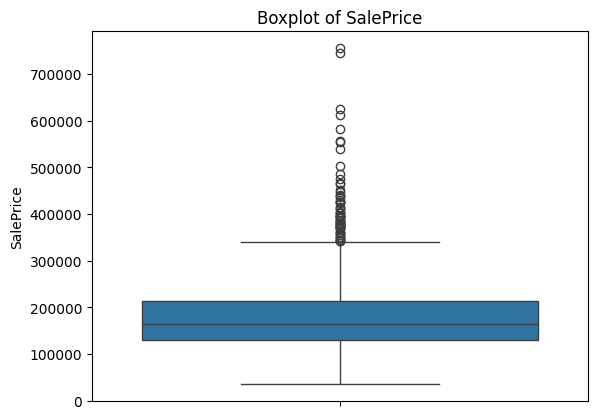

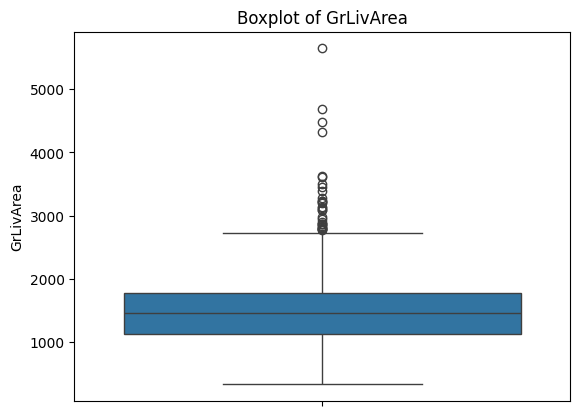

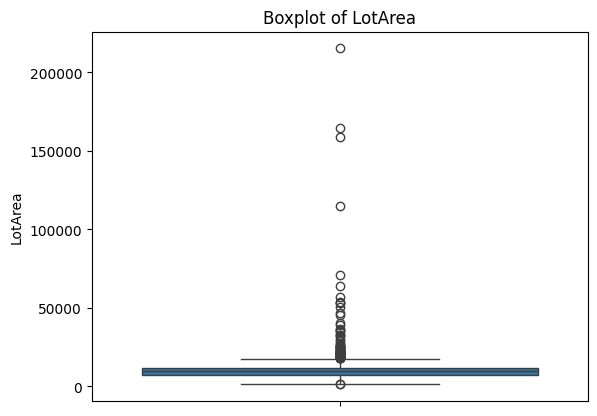

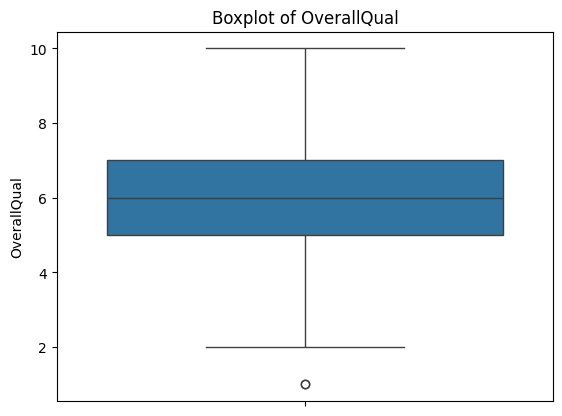

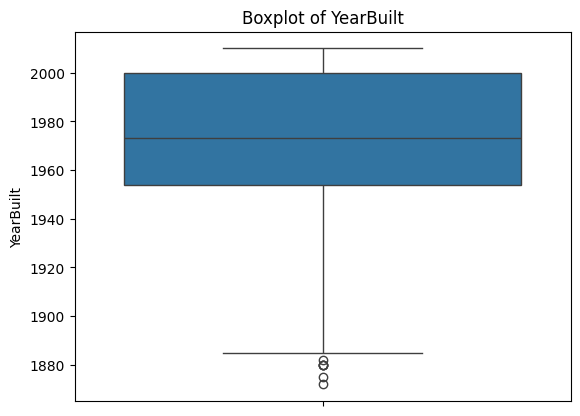

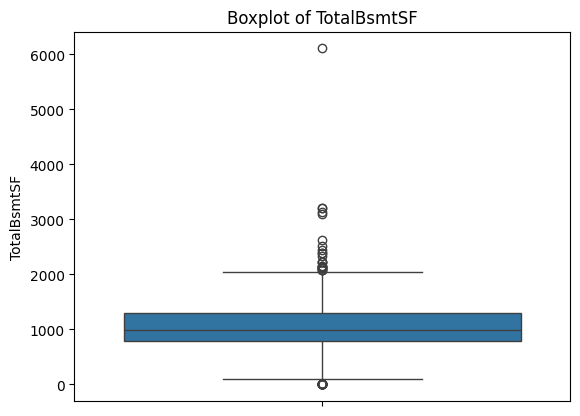

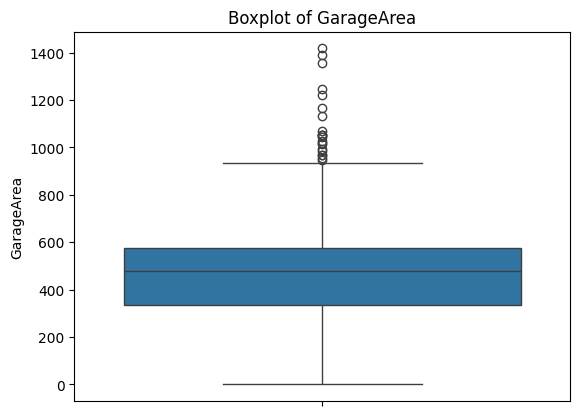

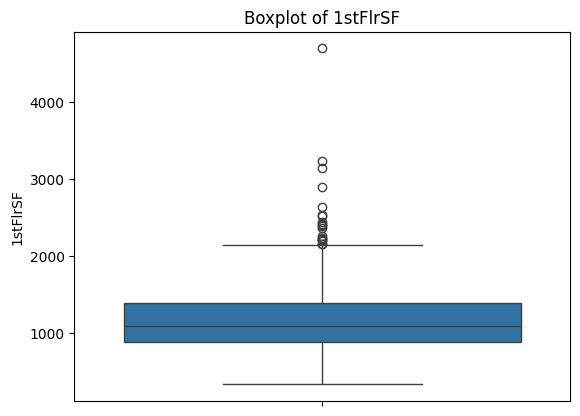

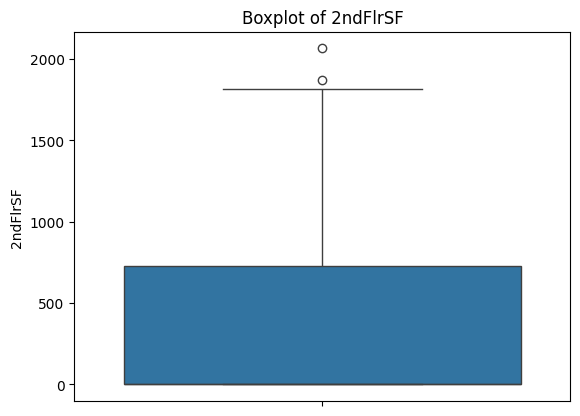

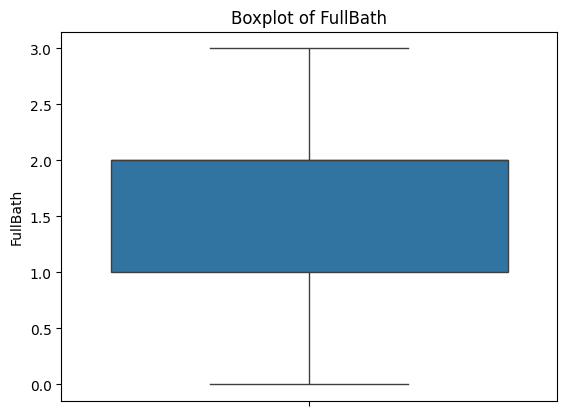

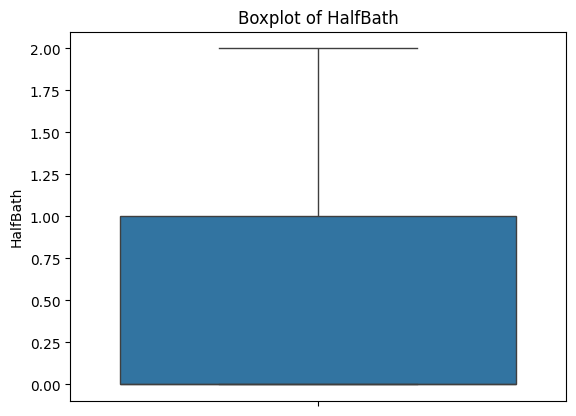

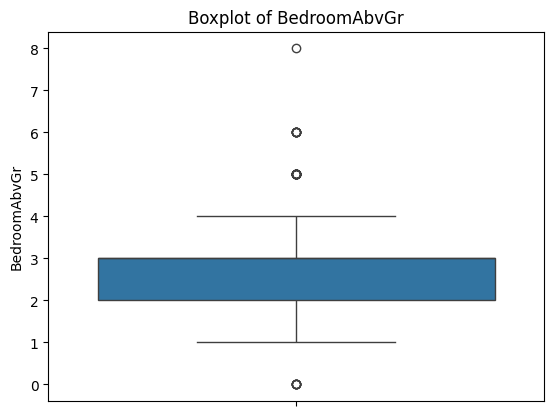

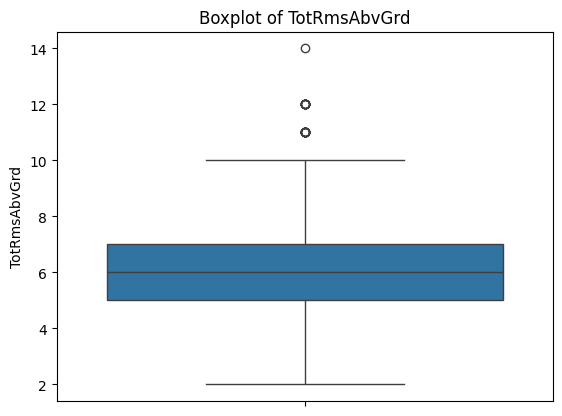

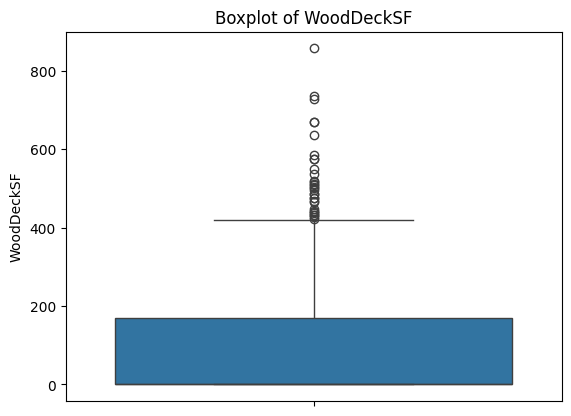

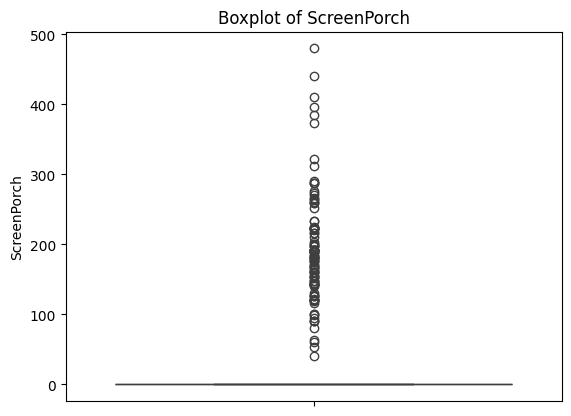

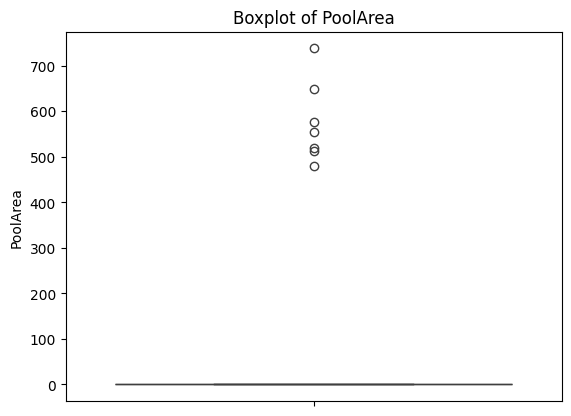

In [15]:
for element in lst:
    plt.figure()
    sns.boxplot(y=train_df[element].dropna())
    plt.title(f'Boxplot of {element}')
    plt.show()

In [25]:
# Fonction pour détecter les outliers via la méthode IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Stocker les seuils pour chaque variable
outlier_bounds = []
outlier_filtered_df = train_df.copy()

for var in lst:
    if var == 'PoolArea' or var == 'ScreenPorch':
        continue
    series = train_df[var].dropna()
    lower, upper = detect_outliers_iqr(series)

    # Enregistrer les bornes
    outlier_bounds.append({
        'Variable': var,
        'Lower Bound': lower,
        'Upper Bound': upper,
        'Nb Outliers (low)': (series < lower).sum(),
        'Nb Outliers (high)': (series > upper).sum()
    })

    # Supprimer les outliers dans une copie du DataFrame
    outlier_filtered_df = outlier_filtered_df[(outlier_filtered_df[var] >= lower) & (outlier_filtered_df[var] <= upper)]

# Résumé sous forme de tableau
outlier_bounds_df = pd.DataFrame(outlier_bounds)

# Afficher les seuils pour l'utilisateur
#import ace_tools as tools; tools.display_dataframe_to_user(name="Outlier Thresholds (IQR Method)", dataframe=outlier_bounds_df)

# Enregistrer le DataFrame filtré sans outliers pour usage futur
filtered_df = outlier_filtered_df.copy().filter(lst)
filtered_df

,SalePrice,GrLivArea,LotArea,OverallQual,YearBuilt,TotalBsmtSF,GarageArea,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,WoodDeckSF,ScreenPorch,PoolArea
0,208500,1710,8450,7,2003,856,548,856,854,2,1,3,8,0,0,0
1,181500,1262,9600,6,1976,1262,460,1262,0,2,0,3,6,298,0,0
2,223500,1786,11250,7,2001,920,608,920,866,2,1,3,6,0,0,0
3,140000,1717,9550,7,1915,756,642,961,756,1,0,3,7,0,0,0
4,250000,2198,14260,8,2000,1145,836,1145,1053,2,1,4,9,192,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,185000,1221,7500,7,2004,1221,400,1221,0,2,0,2,6,0,0,0
1455,175000,1647,7917,6,1999,953,460,953,694,2,1,3,7,0,0,0
1456,210000,2073,13175,6,1978,1542,500,2073,0,2,0,3,7,349,0,0
1457,266500,2340,9042,7,1941,1152,252,1188,1152,2,0,4,9,0,0,0


In [26]:
import statsmodels.api as sm

# Variables pour la régression linéaire
X = filtered_df.drop(columns='SalePrice')
y = filtered_df['SalePrice']

# Ajouter la constante (intercept) au modèle
X = sm.add_constant(X)

# Construire et ajuster le modèle
model = sm.OLS(y, X).fit()

# Résumé du modèle
regression_summary = model.summary()
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     453.3
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:05:19   Log-Likelihood:                -13934.
No. Observations:                1220   AIC:                         2.790e+04
Df Residuals:                    1204   BIC:                         2.798e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.639e+05   6.78e+04    -11.260      0.000   -8.97e+05   -6.31e+05
GrLivArea       26.0333     16.996      1.532      0.126      -7.312      59.378
LotArea          2.2576      0.239      9.437      0.000       1.788       2.727
OverallQual   1.468e+04    814.578     18.021      0.000    1.31e+04    1.63e+04
YearBuilt      368.0728     35.615     10.335      0.000     298.198     437.947
TotalBsmtSF     33.0943      4.645      7.125      0.000      23.981      42.207
GarageArea      29.3470      4.312      6.805      0.000      20.887      37.807
1stFlrSF        23.0444     17.304      1.332      0.183     -10.905      56.994
2ndFlrSF        30.7558     16.856      1.825      0.068      -2.315      63.826
FullBath     -2326.1055   1985.900     -1.171      0.242   -6222.314    1570.103
HalfBath      -262.5049   1946.042     -0.135      0.893   -4080.515    3555.505
BedroomAbvGr -7112.8049   1321.081     -5.384      0.000   -9704.681   -4520.929
TotRmsAbvGrd  -141.0145    911.662     -0.155      0.877   -1929.636    1647.608
WoodDeckSF      32.9227      6.414      5.133      0.000      20.338      45.507
ScreenPorch     44.2276     12.364      3.577      0.000      19.970      68.485
PoolArea        18.9296     25.793      0.734      0.463     -31.674      69.533
==============================================================================
Omnibus:                       82.628   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.844
Skew:                          -0.119   Prob(JB):                     3.96e-77
Kurtosis:                       5.620   Cond. No.                     1.06e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso



In [8]:
# Préparation d'une liste pour stocker les résultats
results = []

# Pour chaque variable
for var in lst:
    data = train_df[var].dropna()  # On enlève les valeurs manquantes
    mean = data.mean()
    variance = data.var()
    n = len(data)
    std_err = stats.sem(data)
    
    # Intervalle de confiance à 95%
    ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=std_err)
    
    # Test d'hypothèse: H0 : mean = median
    median = np.median(data)
    t_stat, p_value = stats.ttest_1samp(data, median)
    
    results.append({
        'Variable': var,
        'Mean': mean,
        'Variance': variance,
        'CI 95% Lower': ci_low,
        'CI 95% Upper': ci_high,
        'T-statistic (mean=median)': t_stat,
        'P-value': p_value
    })

# Résultats dans un DataFrame
results_df = pd.DataFrame(results)
results_df['Significatif ?'] = results_df['P-value'].apply(lambda p: 'Oui' if p < 0.05 else 'Non')
results_df

,Variable,Mean,Variance,CI 95% Lower,CI 95% Upper,T-statistic (mean=median),P-value,Significatif ?
0,SalePrice,180921.195890,6.311111e+09,176842.841041,184999.550740,8.619667,1.718399e-17,Oui
1,GrLivArea,1515.463699,2.761296e+05,1488.487012,1542.440385,3.742148,1.895319e-04,Oui
2,LotArea,10516.828082,9.962565e+07,10004.417990,11029.238175,3.974893,7.385395e-05,Oui
3,OverallQual,6.099315,1.912679e+00,6.028316,6.170314,2.743914,6.145517e-03,Oui
4,YearBuilt,1971.267808,9.122154e+02,1969.717276,1972.818340,-2.191410,2.857975e-02,Oui
5,TotalBsmtSF,1057.429452,1.924624e+05,1034.907554,1079.951351,5.742262,1.134867e-08,Oui
6,GarageArea,472.980137,4.571251e+04,462.003997,483.956277,-1.254549,2.098436e-01,Non
7,1stFlrSF,1162.626712,1.494501e+05,1142.780384,1182.473040,7.474869,1.326539e-13,Oui
8,2ndFlrSF,346.992466,1.905571e+05,324.582323,369.402609,30.372737,1.953089e-157,Oui
9,FullBath,1.565068,3.035082e-01,1.536786,1.593351,-30.165607,9.227600e-156,Oui
